In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

gr.set_default_format("png")

'pdf'

#### Regression in A/B Tests

In [2]:
# treatment is the recommender column which assigns existing benchmark or challenger recommender system
# the outcome of interest is watch_time
data = pd.read_csv("data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [3]:
result = smf.ols('watch_time ~ C(recommender)', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


The data above represents the result of an A/B test, where customers were randomly selected into the treatment group to receive a new recommender system, or the control group. The aim of the experiment was to identify the effect of the new recommender system on customer watch time.

We run a linear regression with one categorical variable for the treatment (why we wrap column name with C) to predict watch time based on which recommender system a customer sees. The intercept $\beta_0$ of a line represents the outcome value when all columns are 0. In this case, it represents the expected watchtime of customers who were using the default recommender system. The coefficient of the recommender column represents the change in the expected watch time due to the new version, and $\beta_0 + \beta_1$ is the expected watch_time for those who got the challenger version (that is when recommender is 1, $watch\_time = \beta_0 + \beta_1$). In otherwords, $\beta_1$
can be seen as an estimate for the ATE. 

Due to reandomization you can assign causal meaning to the estimate and say that the new recommender system increased watch time by 0.14 hours per day on average. However that result is not statistically significant. Using the statsmodels package for the linear regression, we also receive p-values results. Interestingly enough, this demonstrates the use of linear regression to estimate E[Y|T] for each treatment, since in this case, regression is mathematically equivalent to simply doing a comparison between averages.

In [4]:
from sklearn.linear_model import LinearRegression

ln = LinearRegression()
X_data = data.recommender.copy()
X_data.replace({'challenger': 1, 'benchmark': 0}, inplace=True)
ln.fit(X_data.values.reshape(-1,1), data.watch_time.values)

LinearRegression()

In [5]:
ln.coef_

array([0.14268596])

In [6]:
ln.intercept_

2.049064039408867

In [7]:
# regression is estimating E[Y|T] for each treatment
(data.groupby("recommender")["watch_time"].mean())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

In [8]:
# because we have one categorical variable, the intercept is expected outcome for class 0,
# coefficient of categorical variable is the increase ie ATE in this example
2.191750 - 2.049064

0.14268599999999987

In [9]:
# treatment is credit_limit
risk_data = pd.read_csv('data/risk_data.csv')
risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [10]:
risk_data.credit_limit.nunique()

83

Because the treatment, credit_limit, is continuous, we can't represent ATE as the difference between multiple levels of the treatment. Instead, you can represent it as the derivative of the expected outcome with respect to the treatment: 

$ATE=\frac{d}{dt}E[y|t]$

$Default_i = \beta_0 + \beta_1limit_i + e_i$

$\hat\beta_i$ can be interpreted as the amout you expect risk to change given a 1 USD increase in limit. This parameter has causal interpretation if the limit was randomized. However, that is not the case as banks tend to give higher lines to customers who are less risky. In fact, after running the regression model, you'll get a negative estimate for $\hat\beta_i$.

In [11]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit() # initialize and fit linear regression
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


In [12]:
plt_df = (risk_data
          .assign(size=1)                                   # add a column with 1's for calculating group size
          .groupby("credit_limit")                          # treating credit_limit as categorical here
          .agg({"default": "mean", "size": sum})            # default rate and count for each credit limit
          .reset_index()                                    
          .assign(prediction = lambda d: # predict risk of defaulting
                  model.predict(d))) # statsmodels model uses default, credit_limit cols , so name agg 'default'
plt_df

,credit_limit,default,size,prediction
0,200.0,0.211445,1031,0.214418
1,300.0,0.156863,255,0.212016
2,400.0,0.215686,255,0.209614
3,500.0,0.205970,335,0.207212
4,600.0,0.218837,361,0.204810
...,...,...,...,...
78,8000.0,0.250000,4,0.027065
79,8100.0,0.166667,6,0.024663
80,8200.0,0.000000,2,0.022261
81,8300.0,0.000000,1,0.019859


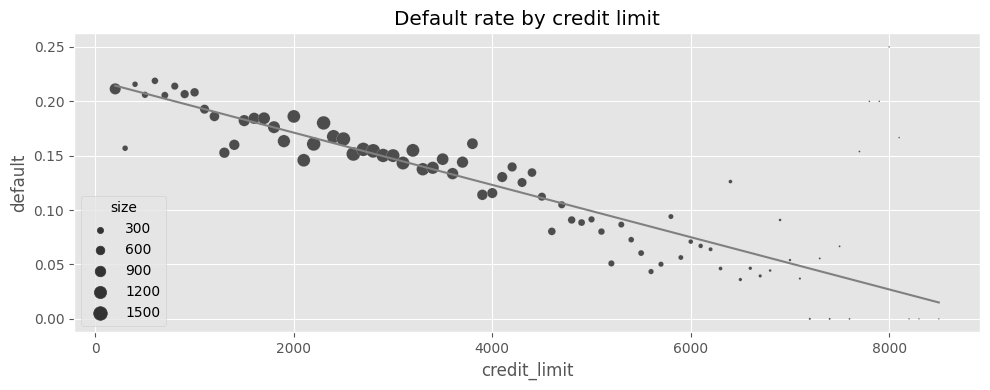

In [13]:
plt.figure(figsize=(10,4))

# seaborn to plot scatter plot  of credit limit vs observed default rate ; 
# relative sizes based on credit limit group size
sns.scatterplot(data=plt_df,
                x="credit_limit",   # plot credit limit vs default rate
                y="default",        # this isnt the categorical target but the observed default rate 
                size="size",        # relative point size based on number of accounts assigned said credit_limit
                sizes=(1,100))      # relative point sizes to use

# matplotlib to plot regression line of credit limit vs predicted default rate (risk of default) 
plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default rate by credit limit")
plt.tight_layout()

To adjust for bias, in theory, one could segment the data by all confounders, run a regression of default on credit lines inside each segment, extract the slope parameter (which represents ATE for the segment) and average the results (weighted by segment size of course ie the adjustment formula). Such confounder variable (that causes both treatment, credit limit, and the outcome default) are credit scores and wage information. Customers with higher wages and credit scores are likely to get assigned credit limits because they represent lower risk of default.

Estimating the ATE in each of those segments and averaging the result is only possible if you have massive amounts of data. This is the curse of dimensionality, and in the context of causal inference, one implication of this curse is that a naive application of the adjustment formula will suffer from data sparsity if you have lots of covariates. 

In [14]:
# grouping samples by confounders ie credit scores 
risk_data.groupby(["credit_score1", "credit_score2"]).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

One way out of the dimensionality problem is to assume that potential outcome can be modeled by something like linear regression, which we can then interpolate and extrapolate many individual X defined cells (segments). Instead of manually adjusting for confounders, you can simply add them to the model you'll estimate with OLS.

$Default_i=\beta_0+\beta_1 limit_1+\theta X_i+e_i$ 

$X$ is a vector of confounder variables and $\theta$ is the vector of parameters associated with those confounders. $\theta$ values act like $\beta_1$ (the parameter associated with the treatment), and are technically called nuisance parameters.

$Default_i = \beta_0+\beta_1 limit_1+ \theta_1 wage_i +  \theta_2 creditScore1_i + \theta_3 creditScore2_i+ e_i $

The preceding model is a model for $E[y|t,X]$, the expected value of outcome y given the treatment, credit_limit, and the values of the confounder variables, wage and credit scores. If you differentiate the model with respect to treatment ie $\frac{d}{dt}E[y|t,X]$, you simply get $\beta_1$. In a sense $\beta_1$ can be seen as the partial derivative of the expected value of default with respect to credit limit. Intuitively, $\beta_1$ represents how much you should expect default to change, given a small increase in credit limit, while holding fixed all other variables in the model. That is, regression adjusts for confounders, by holding them fixed while estimating the relationship between treatment and outcome. For the preceding model, adding some confounders makes the relationship between credit lines and default to become positive (an increase in credit limit will cause the an increase in default), because the confounders now account for the fact that an increase in wage and credit scores will cause a decrease in default.

In [15]:
# adding confounders to the model
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


The Frisch-Waugh-Lovell theorem is an incredible way to get rid of bias and can be used as a debiasing pre-processing step. That is the Frisch-Waugh-Lovell theorem allows you to separate the debiasing step from the impact estimation step. To understand, how this works, one needs to look at a bit of regression theory. Linear regression finds the parameters that minimize the mean squared error (MSE).

$\beta^*=argmin_{\beta}E[{(Y_i - X_i^{'} \beta)}^2]$

If you differentiate it and set it to zero, you will find that the linear solution to this problem. You can then estimate $\beta$ using the sample equivalent.

$\beta^*=E[X^{'}X]^{-1}E[X^{'}Y]$

$\hat \beta = (X^{'}X)^{-1}X^{'}Y$

In [16]:
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"] # columns for modeling
X = risk_data[X_cols].assign(intercept=1)  # add interept as final variable, so first parameter estimate is β_1
y = risk_data["default"]

# closed form solution to ordinary least squares
def regress(y,X):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y,X) # with intercept added use the closed form solution to estimate beta parameters
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

In causal inference, you often want to estimate the causal impact of a variable T on an outcome y, and you can use regression with this single variable to estimate this effect. With a single regressor variable T, the parameter associated to it is given by:

$\hat \tau = \frac{Cov(Y_i, T_i)}{Var(T_i)}=\frac{E[(T_i - \bar T)(Y_i - \bar Y)]}{E[(T_i - \bar T)^2]}$

If treatment, $T$ is randomly assigned, $\beta_1$ is the ATE. This formula shows more clearly, what regression is doing. It's finding out how the treatment and outcome move together (as expressed by the covariance in the numerator) and scaling this by the units in the treatment (by dividing by the variance of the treatment). Covariance is related to dot products, so in the ols closed form solution, $X^{'}X$ takes the role of the denominator in the covariance/variance formula, $E[(T_i - \hat T)^2]$ , while $X^{'}y$ takes the role of the numerator.

If you have more than one regressor (multivariate linear regression), you can extend the one variable regression to shed some light into what regression is doing. You can say those other variables are just auxilliary and that you are truly interested in estimating the parameter $\tau$ associated to T.

$y_i = \beta_0 + \tau T_i + \beta_1 X_{1i} + ... + \beta_k X_{ki} + u_i$

$\hat \tau = \frac{Cov(Y_i, \widetilde {T_i})}{Var(\widetilde {T_i})}$

where $\widetilde {T_i}$ is the residual from a regression of $T_i$ on all of the other covariates $ X_{1i} + ... + X_{ki}$ . 

If you can predict the treatment $T$ using other variables, it means its not random. However, you can make $T$ look as good as random once you control for all the confounder variables $X$. To do so, use linear regression to predict $T$ from the confounder and then take the residuals of that regression $\widetilde T$. By definition, the residuals of linear regression, $\widetilde T$, cannot be predicted by the other variables $X$ that you've already used to predict $T$. Thus, $\widetilde T$ is a version of the treatment $T$, that is not associated (uncorrelated) with any other variable in X.



In [17]:
np.cov(y, X.credit_limit)

array([[ 1.28061921e-01, -4.52552611e+01],
       [-4.52552611e+01,  1.88409564e+06]])

In [18]:
np.var(X.credit_limit)

1884057.9551

In [19]:
(np.cov(y, X.credit_limit) / np.var(X.credit_limit))[0][1]

-2.4020100327975362e-05

#### Frisch-Waugh-Lovell Theorem and Orthogonalization

FWL orthogonalization is the first major debiasing technique. Even though FWL is about linear regression, FWL-style orthogonalization has been expanded to work in more general contexts. Frisch-Waugh-Lovell theorem states that a multivariate linear regression model can be estimated all at once or in three separate steps:

1. A debiasing step, where you regress the treatment T on confounders X and obtain the treatment residuals $\widetilde T = T - \hat T$

2. A denoising step, where you regress the outcome Y on the confounder variables X and obtain the outcome residuals
$\widetilde Y = Y - \hat Y$

3. An outcome model, where you regress the outcome residual $\widetilde Y$ on the treatment residual $\widetilde T $ to obtain an estimate for the causal effect of T on Y

In [20]:
# multivariable regression (outcome regressed on treatment and confounders (common causes))
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


#### Debiasing Step

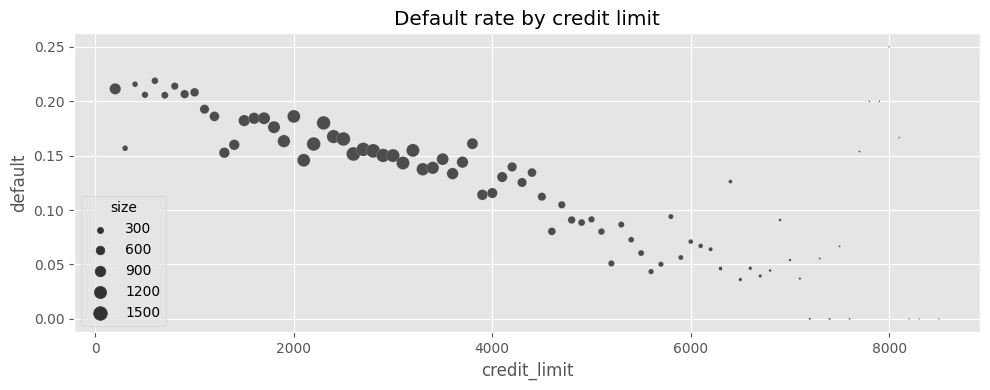

In [21]:
plt_df = (risk_data
          .assign(size=1)                                   # add a column with 1's for calculating group size
          .groupby("credit_limit")                          # treating credit_limit as categorical here
          .agg({"default": "mean", "size": sum})            # default rate and count for each credit limit
          .reset_index())

plt.figure(figsize=(10,4))

# seaborn to plot scatter plot  of credit limit vs observed default rate ; 
# relative sizes based on credit limit group size
sns.scatterplot(data=plt_df,
                x="credit_limit",   # plot credit limit vs default rate
                y="default",        # this isnt the categorical target but the observed default rate 
                size="size",        # relative point size based on number of accounts assigned said credit_limit
                sizes=(1,100))      # relative point sizes to use

plt.title("Default rate by credit limit")
plt.tight_layout()

In [22]:
# Debiasing Step, regression using confounders to predict treatment and obtaining residuals
debiasing_model = smf.ols(
    'credit_limit ~ wage + credit_score1 + credit_score2',
    data = risk_data 
).fit()

risk_data_deb = risk_data.assign(
    # for visualization, avg(T) is added to the residuals to put it in same range as original
    credit_limit_res = (debiasing_model.resid +               # adding avg(T) doesnt change coefficients below
                        risk_data["credit_limit"].mean())
)
risk_data_deb.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default,credit_limit_res
0,950.0,11,16,1,500.0,518.0,3200.0,0,3347.583906
1,780.0,11,7,1,414.0,429.0,1700.0,0,2331.086567
2,1230.0,14,9,1,586.0,571.0,4200.0,0,3665.134174
3,1040.0,15,8,1,379.0,411.0,1500.0,0,1720.933260
4,1000.0,16,1,1,379.0,518.0,1800.0,0,2084.659827


In [23]:
# regression using residuals from debiasing step to predict the outcome
model_w_deb_data = smf.ols('default ~ credit_limit_res', data=risk_data_deb).fit()
model_w_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


The fact that you only need to residualize treatment suggests a simpler way of rewriting regression coefficient formula. In the single variable case, instead of using covariance of Y and T over the variance of T, you can use

$\beta_1 = \frac{E[(T_i - \bar T)y_i]}{E[(T_i - \bar T)^2]}$

In the multivariate case, this would be

$\beta_1 = \frac{E[(T_i - E[T|X])y_i]}{E[Var(T | X)]}$

In [24]:
a = (X.credit_limit - X.credit_limit.mean())            # residualize treatment (naive prediction of mean)
b = (a*risk_data.default).mean()                        # multiply by outcome, and take expected value (mean)
c = (a*a).mean()                            # denominator, expected value of square of residualized treatment
d = b/c                                     # divide numerator by denominator
d                                           # effect of treatment (not accounting for confounders)

-2.4019619925968827e-05

In [25]:
# data to plot debiased version of treatment against outcome
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2)) # round up debiased treatment
          .groupby("credit_limit_res") # treat the debiased treatment as a categorical variable
          .agg({"default": "mean", "size": sum}) # average outcome and size of each debiased treatment
          .query("size > 30") # filter for large groups
          .reset_index()      # add credit_limit_res back as a column
          )
plt_df.head()

,credit_limit_res,default,size
0,0.0,0.062500,32
1,100.0,0.108108,37
2,200.0,0.134615,52
3,300.0,0.051282,78
4,400.0,0.051948,77


Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

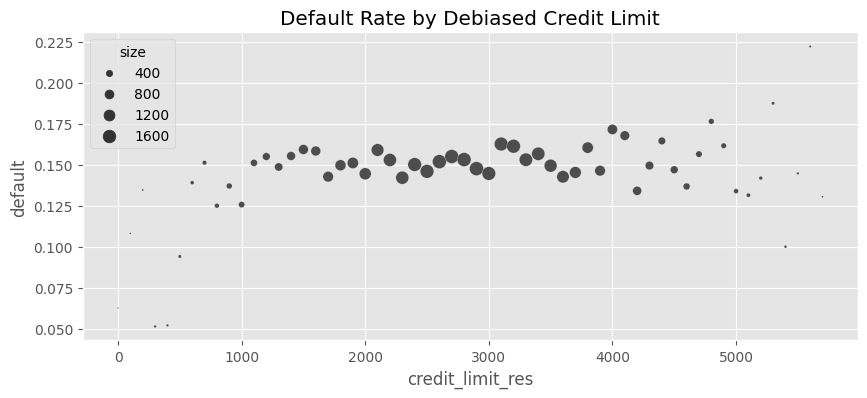

In [26]:
# plot debiased version of treatment against outcome
plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))
plt.title("Default Rate by Debiased Credit Limit")

#### Denoising Step

Debiasing is crucial to estimating the correct causal effect. Denoising won't change the value of the treatment effect, but it will reduce its variance. In denoising, you regress the outcome on the covariates that are not the treatment. Then you get the residual for the outcome. For better visualization, you can add the average outcome value to the denoised outcome variable to plot in a similar range as the original data.

In [27]:
# first regress the outcome on the covariates that are not the treatment
denoising_model = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',
    data=risk_data_deb
).fit()

# obtain the residual of the outcome based on the denoising model
# for visualization purposes, add average default rate to denoised outcome variable
risk_data_denoise = risk_data_deb.assign(
    default_res = denoising_model.resid + risk_data_deb["default"].mean() # residuals plus average default
)

#### Standard Error of the Regression Estimator

The standard error of the regression parameter estimate is given by 

$SE(\hat \beta) = \frac{\sigma(\hat \epsilon)}{\sigma(\widetilde T)\sqrt{n-DF}}$

where $\hat \epsilon$ is the residual from the regression model that estimates the outcome from the confounders and DF is the model's degree of freedom (number of parameters estimated by the model). For statsmodels to get its standard error values, first regress the outcome against the features  and obtain the standard deviation of the residuals for the numerator. Then for any feature, regress current feature against the remaining features and obtain the standard deviation of the residuals for the denominator (together with the difference between number of samples and number of parameters estimated). This is how we get the standard error of the parameter estimate for any feature (covariate).

The numerator tells you that the better the confounders can predict the outcome, the smaller the residuals will be, and hence the lower the variance of the estimate (which is the aim of the denoising step). Interestingly, the error is also inversely proportional to the variance of the residualized treatment. Intuitively, if the treatment varies a lot, it will be easier to measure its impact.

For continuous treatment, the standard error is


$SE≈ \frac{\sigma_y} {\sigma_T(n−2)}$

In [28]:
# regression of the outcome against the covariates that are not the treatment
model_se = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',  # outcome against all confounders
    data = risk_data
).fit()

print("SE regression:", model_se.bse["wage"])

# using formula
model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data = risk_data
).fit()

# subtract the degrees of freedom - 4 model parameters - from N.
se_formula = (np.std(model_se.resid) / (np.std(model_wage_aux.resid)*np.sqrt(len(risk_data) - 4)))


SE regression: 5.364242347548246e-06


#### Final Outcome Model

With both residuals, $\widetilde Y$ and $\widetilde T$, you can run the final step outlined by the FWL therem by regressing $\widetilde Y$ on $\widetilde T$.

In [31]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data = risk_data_denoise).fit()
model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit')

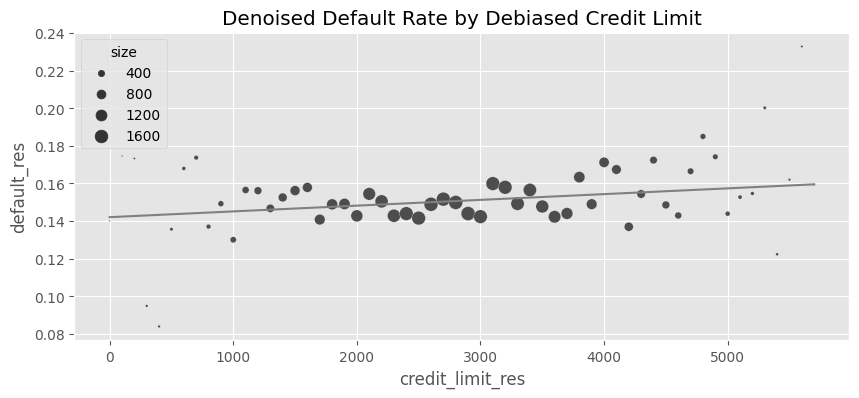

In [32]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d['credit_limit_res'].round(-2))
          .groupby('credit_limit_res')  # treat the residualized limit (with average) as categories
          .agg({'default_res': 'mean', 'size': sum}) # for each category calculate mean and size
          .query('size>30')
          .reset_index()
          .assign(prediction = lambda d: 
                  model_w_orthogonal.predict(d)) # use credit_limt_res to predict default_res
          )

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x='credit_limit_res',  # residualized treatment vs residualized outcome (average increased)
                y='default_res',
                size='size',
                sizes=(1,100))
plt.plot(plt_df['credit_limit_res'], plt_df['prediction'], c='C1')
plt.title('Denoised Default Rate by Debiased Credit Limit')

#### Regression as an Outcome Model

In addition to orthogonalizing the treatment, regression can also be seen as a potential outcome imputation technique . For a binary treatment, if regression of Y on C in the control population (T=0) yields a good approximation to $E[Y_0|X]$, then you can use that regression model ($\hat \mu_0$)to impute $Y_0$ and estimate the average treatment effect on the treated ($ATT$). 

$ATT = \frac{1}{N_1}\Sigma １(T_i=1)(Y_i - \hat \mu_0 (X_i))$

１(﹒) is the indicator function that returns 1 when the argument inside it evaluates to true and zero otherwise. $N_1$ is the number of treated units. Since regression model $\hat \mu_0$ was trained on the control population, it outputs the potential outcome of no treatment $Y_{0i}$. For the treated group $Y_i$, the observed outcome is equal to the potential outcome when treated $Y_{1i}$.

A similar argument can be made to show that if regression on the treated units can model $E[Y_1|X]$, you can use it to estimate the average effect on the untreated. If you put these two argumentss side by side, you can estimate the ATE as :

$ATE = \frac{1}{N}\Sigma(\hat \mu_1(X_i) - \hat \mu_0(X_i))$

This estimator will impute both potential outcomes for all units. It is equivalent to regressing Y on both X and T and reading the parameter estimate on T.

Alternatively, you can impute just the potential outcomes that are missing:

$ATE = \frac{1}{N}\Sigma(１(T_i=1)[Y_i - \hat \mu_0(X_i)] + １(T_i=0)[\hat \mu_1(X_i) - Y_i])$

When $T$ is continuous (such as credit limit in the risk data example), this is a bit harder to conceptualize, but you can understand regression as imputing the whole treatment response function, which involves imputing potential outcomes ($Y_t$) as if it was a line. 

In otherwords, regression can be used in two ways, by either correctly estimating $E[T|X]$ for orthogonalization or correctly  estimating the potential outcomes $E[Y_t|X]$.

#### Positivity and Extrapolation

Regression models potential outcome as a parametric function, and this allows for extrapolation outside the region where you have data on all treatment levels. This can be a blessing or a curse depending on whether the extrapolation is reasonable. In the plot below, we have Dataset 1, which has only control units for low values of a covariate $x$ and only treatment units for high values of the same covariate. We then use regression to estimate potential outcomes $Y_0$ and $Y_1$. The extrapolation of $Y_0$ for the control will be fine as long as the relationship between $Y_0$ and $x$ is the same for high and low values of $x$. In the same way, the extrapolation of $Y_1$ for the treated will be fine as long as the relationship between $Y_1$ is the same for high and low values of x. The validity of extrapolation in regions where you don't have positivity is demonstrated in Dataset 2, which represents collection of more data and randomization of treatment after estimating the effect on Dataset 1.

(-4.0, 6.0)

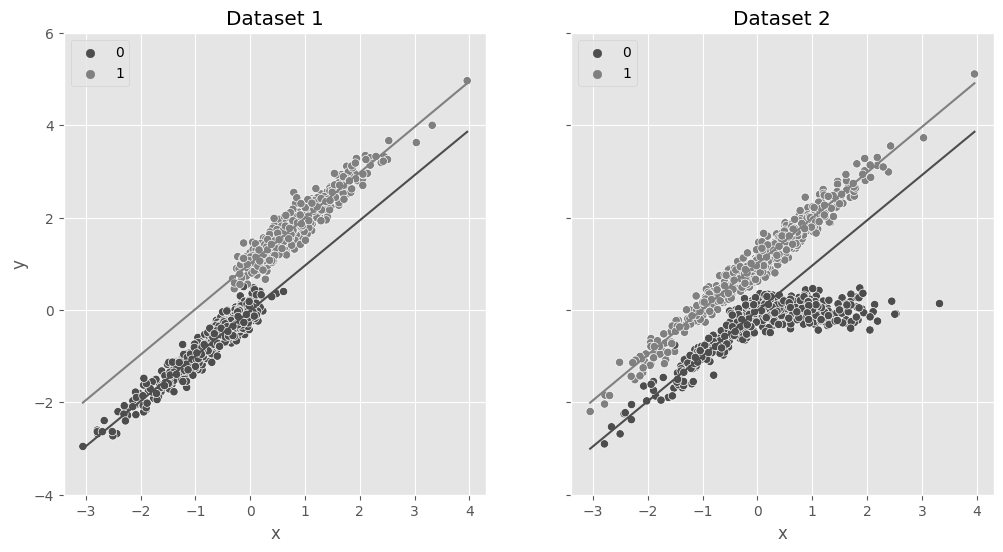

In [33]:
np.random.seed(1)

n = 1000                                # number of data points
x = np.random.normal(0, 1, n)           # n values normal distribution of mean=0, std=1
t = np.random.normal(x, 0.2, n) > 0     # binary treatment (normal dist centered on each x val>0 ~ 50:50 levels)

y0 = x                                  # potential outcome with no treatment
y1 = 1 + x                              # potential outcome with treatment

y = np.random.normal((1-t)*y0 + t*y1, 0.2)      # observed outcome (using normal dist centered on y vals)

df_no_pos = pd.DataFrame(dict(x=x, t=t.astype(int), y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1)

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()    # μ_0, regression of y on control group
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()    # μ_1, regression of y on treatment group  

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1)
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000                                    # number of data points
x = np.random.normal(0, 1, n)               # n values normal distribution of mean=0, std=1
t = np.random.binomial(1, 0.5, size=n)      # binary treatment from binomial distribution of 50% prob of success

y0 = x * (x<0) + (x>0)*0                    # potential outcome with no treatment
y1 = 1 + x                                  # potential outcome with treatment

y = np.random.normal((1-t)*y0 + t*y1, 0.2)  # observed outcome

df_pos = pd.DataFrame(dict(x=x, t=t.astype(int), y=y))

sns.scatterplot(data=df_pos, x="x", y="y", hue="t", ax=ax2)

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")

ax1.set_ylim(-4, 6)

#### Non-Linearities in Linear Regression

Sometimes, the treatment response curve is not linear. This is essential because when we use regression to estimate a causal effect via orthogonalization, we are still assuming a linear relationship between the debiased treatment and denoised outcome and this is simply not the case sometimes. This means that the effect of the treatment on the outcome is not constant since causal effect is related to slope. 

For the example below, we plot the credit lines against average spending for different wage groups (represented by the middle wage in each wage group). Since the relationship is concave, then in causal inference language, we say,  that the effect of credit lines diminishes on spending diminishes as you increase lines.

In [34]:
spend_data = pd.read_csv("data/spend_data.csv")
spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


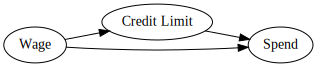

In [35]:
# the only confounder we are considering is that wage affects both credit_limit and spending
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})
g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")
g_risk

<Axes: xlabel='credit_limit', ylabel='spend'>

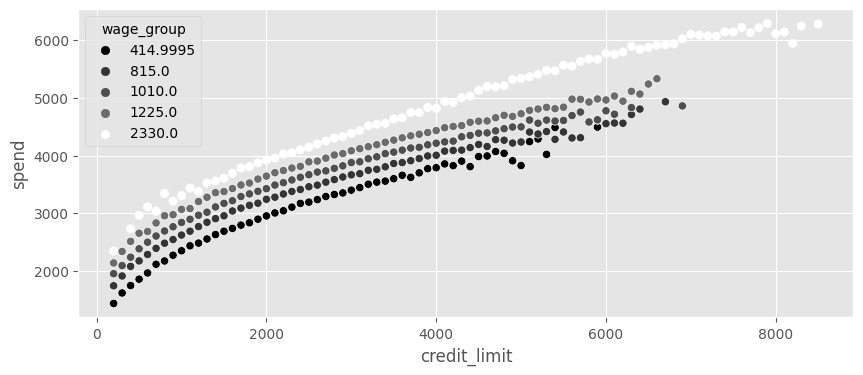

In [36]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"],5)).mid) # quantiles, index, middle 
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]       
          .mean()           # average spending (outcome) for each wage_group and credit_limit (treatment)
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")

#### Linearizing the Treatment

To deal with nonlinearities, we first need to transform the treatment into something that does have a linear relationship with the outcome. In the example above, since the relationship seems concave, we can apply some concave function to the lines, such as the log function, the square root function, or any function that takes the credit lines (treatment) to the power of a fraction.

<Axes: xlabel='credit_limit_sqrt', ylabel='spend'>

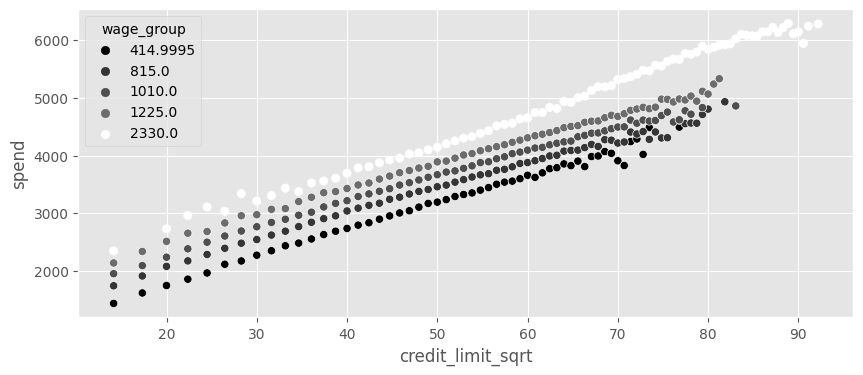

In [37]:
plt_df = (spend_data
          .assign(credit_limit_sqrt = np.sqrt(spend_data['credit_limit'])) # linearize
          .assign(wage_group=pd.IntervalIndex(pd.qcut(spend_data['wage'], 5)).mid) # 5 quantile wage_groups
          .groupby(['wage_group', 'credit_limit_sqrt'])  # use the linearized treatment
          [['spend']]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x='credit_limit_sqrt',
                y='spend',
                palette='gray',
                hue='wage_group')

When we use the square root function and plot the square root of the credit limit against spending, we get a linear function. Thus we use this to build the model:

$spend_i = \beta_0 + \beta_1 \sqrt{line_1}+e_i$ where the causal parameter is $\beta_1$

In [38]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)', data=spend_data
).fit()
model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


<Axes: xlabel='credit_limit', ylabel='spend'>

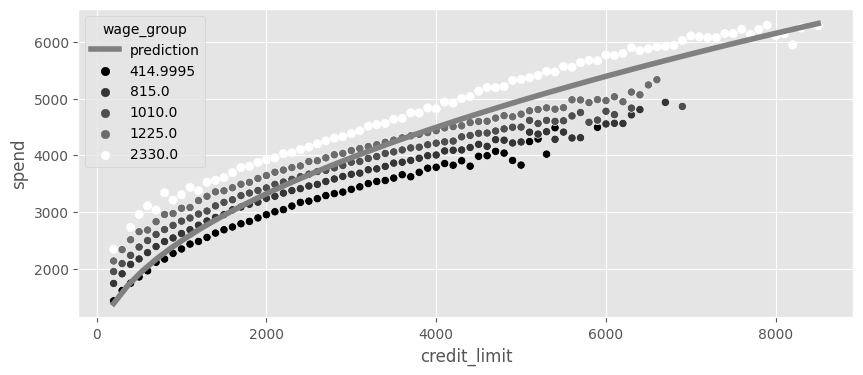

In [39]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d['wage'],5)).mid) # confounder
          .groupby(['wage_group', 'credit_limit'])
          [['spend']]
          .mean()       # for each wage group, for each credit_limit, average spending
          .reset_index()
          )

x = np.linspace(plt_df['credit_limit'].min(), 
                plt_df['credit_limit'].max()) # linearly spaced min-max credit_limit

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), 
         color='C1', label='prediction', lw=4)  # spend_i = intercept + slope * √credit_limit
plt.legend()
sns.scatterplot(data=plt_df,
                x='credit_limit',
                y='spend',
                palette='gray',
                hue='wage_group')

When we plot the model against the original data, we notice an upward biased because more wage causes both spend and credit lines to increase. This is not surprising because wage is a confounder. To address this, we include wage in the model:

$spend_i = \beta_0 + \beta_1 \sqrt{line_1}+ \beta_2 wage_i + e_i$

When we estimate $\beta_1$ again, we get then unbiased estimate of the effect of credit lines on spending. This estimate is smaller than before (43 vs 63) because wage in the model fixed the upward bias.

In [40]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit) + wage', data=spend_data).fit()
model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


#### Nonlinear FWL and Debiasing

Just apply the linearizing function to treatment before the debiasing step. The reamining steps are the same as before. When we apply this to the credit lines vs spending dataset where wage is the confounding variable, we see that the prediction is no longer upward biased but rather goes through the middle of the wage groups.

In [41]:
# apply linearizing function (square root) to treatment (credit limit), regress against confounder (wage)
debias_spend_model = smf.ols(f'np.sqrt(credit_limit) ~ wage', data=spend_data).fit() # treatment vs confounder
# regress outcome, spending against confounder, wage
denoise_spend_model = smf.ols(f'spend ~ wage', data=spend_data).fit()
# add square root of the average treatment, credit limit, to debias model's residuals (for visualization)
credit_limit_sqrt_deb = (debias_spend_model.resid + np.sqrt(spend_data['credit_limit']).mean())
# add average of outcome to denoise model's residuals (for visualization)
spend_den = denoise_spend_model.resid + spend_data['spend'].mean()
# put augmented residuals' data into a dataframe for next model building
spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb, spend_den=spend_den))
# regress outcome residuals against treatment residuals
final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb', data=spend_data_deb).fit()
# check the causal effect (coefficient)
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


<Axes: xlabel='credit_limit', ylabel='spend'>

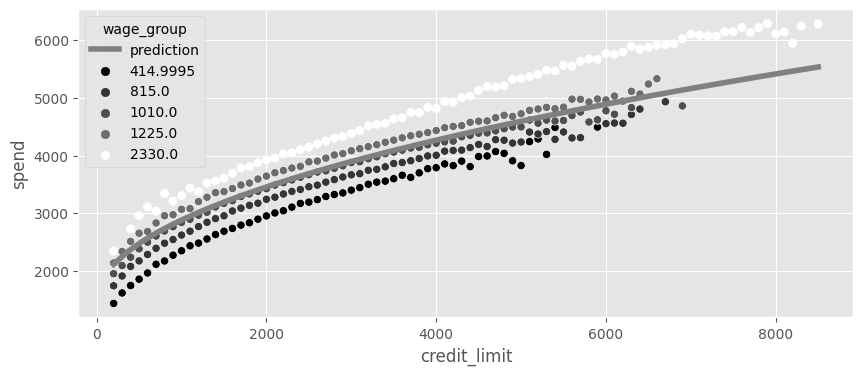

In [42]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d['wage'],5)).mid)
          .groupby(['wage_group', 'credit_limit'])
          [['spend']]
          .mean()       # for each wage group, for each credit_limit, average spending
          .reset_index()
          )

x = np.linspace(plt_df['credit_limit'].min(), 
                plt_df['credit_limit'].max()) # linearly spaced min-max credit_limit

plt.figure(figsize=(10,4))
plt.plot(x, final_model.params[0] + final_model.params[1]*np.sqrt(x), 
         color='C1', label='prediction', lw=4)  # spend_i = intercept + slope * √credit_limit
plt.legend()
sns.scatterplot(data=plt_df,
                x='credit_limit',
                y='spend',
                palette='gray',
                hue='wage_group')

In [43]:
model_spend.params

Intercept                383.500167
np.sqrt(credit_limit)     43.850400
wage                       1.045860
dtype: float64

In [44]:
final_model.params

Intercept                1493.698994
credit_limit_sqrt_deb      43.850400
dtype: float64

#### Conditionally (stratified) random experiments

Regression and orthogonalization require an independence assumption that treatment looks as good as randomly assigned, when some covariates are accounted for. However, it can be very hard to know if all confounders have been included in the model. In most applications, the ideal of a randomized controlled trial is not possible, so the next best thing is stratified or conditionally random experiments. Instead of random draws from the same probability distribution, you create multiple local experiments, where you draw samples from different distributions depending on certain covariates. For example in the banking example, credit_score1 is a proxy for customer risk. So you can create groups of customers that are more or less risky, dividing them into buckets of similar credit_score1. Then for the high-risk bucket- with low credit_score1- you randomize credit lines by sampling from a distribution with a lower average for low-risk customers;- with high credit_score1- you randomize credit lines by sampling from a distribution with a higher average.

In [45]:
risk_data_rnd = pd.read_csv('data/risk_data_rnd.csv')
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


Text(0.5, 1.0, 'Conditional random experiment')

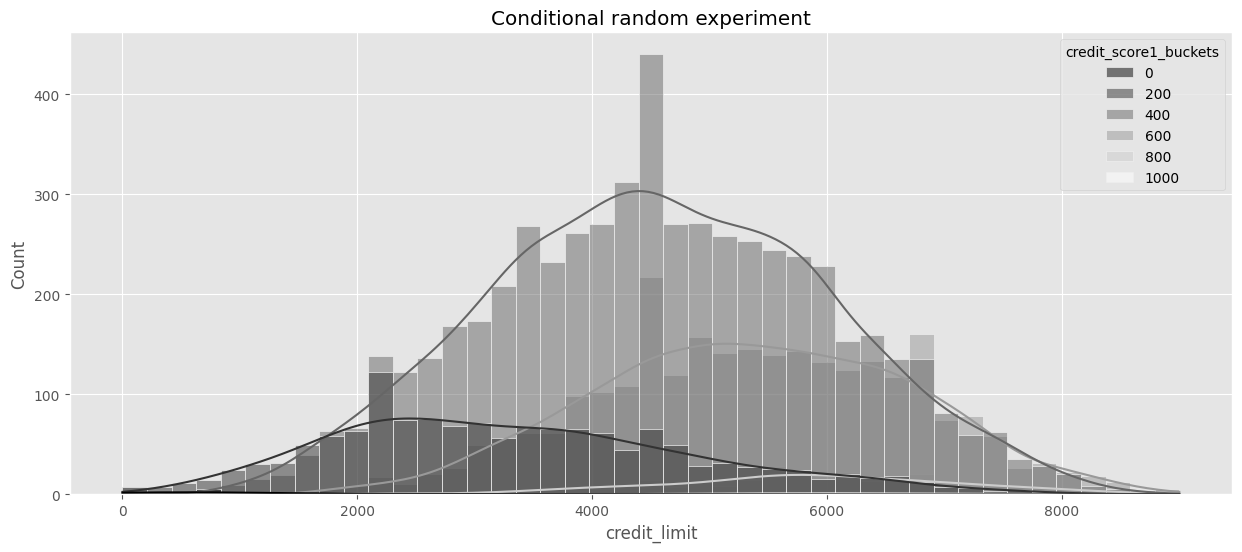

In [46]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x='credit_limit',
             hue='credit_score1_buckets',
             kde=True,                          # draw pdf line
             palette='gray')
plt.title('Conditional random experiment')

#### Dummy Variables

The thing about conditionally random experiments is that the conditional independence assumption is much more plausible, as the lines were randomly assigned given a categorical variable of your choice. A simple regression of the outcome on the treated will yield a biased estimate. 

$default_i=\beta_0+\beta_1lines_i+e_i$

To adjust for that, you need to include in the model, the group within which the treatment is randomly assigned. This group is a categorical variable so you need dummy variables (one-hot encoding). A dummy is binary column for a group. It is 1 if a sample belongs to that group and 0 otherwise. A sample can only be from one group, so at most one dummy column will be 1, with all the others being zero. Once you have the dummy columns, you can add them to your model and estimate $\beta_1$ again.

$default_i=\beta_0+\beta_1lines_i+ \theta G_i + e_i$

In [47]:
model = smf.ols("default ~ credit_limit", data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


In [48]:
risk_data_dummies = (
    risk_data_rnd.join(pd.get_dummies(risk_data_rnd['credit_score1_buckets'],
                                      prefix='sb',
                                      drop_first=True,
                                      dtype=int))
)
risk_data_dummies.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default,sb_200,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,490.0,500.0,400,5400.0,0,0,1,0,0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0,1,0,0,0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0,0,1,0,0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0,0,0,1,0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0,1,0,0,0,0


In [49]:
model = smf.ols(
    "default ~ credit_limit + sb_200 + sb_400 + sb_600 + sb_800 + sb_1000",
    data=risk_data_dummies
).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06
sb_200,-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400,-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600,-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800,-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000,-0.2541,0.094,-2.715,0.007,-0.438,-0.071


In [50]:
# In statsmodels, the C() function in the formula can do all of the dummy variables
model = smf.ols("default ~ credit_limit + C(credit_score1_buckets)", 
                data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


Adding dummies to control for confounding gives one intercept per group, but the same slope for all groups. This slope is a variance weighed average of the regression in each group. If you plot the model's predictions for each group, you see one line per group, but all of them have the same slope.

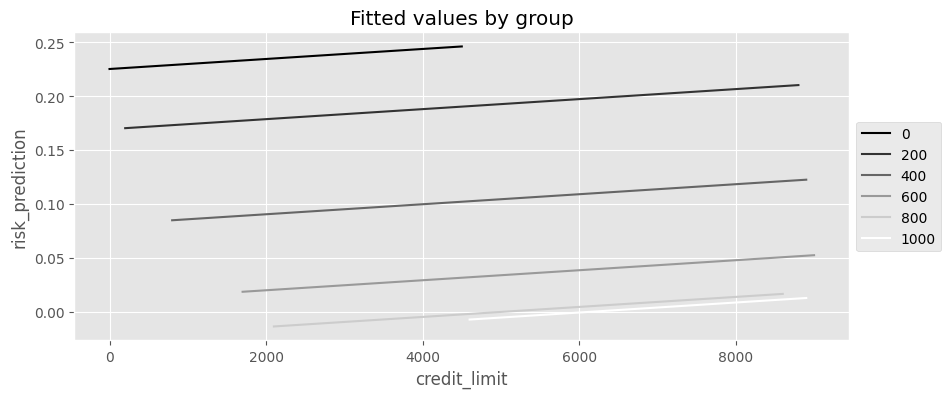

In [51]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)  # statsmodels predictions given by fittedvalues
          .groupby(['credit_limit', 'credit_score1_buckets'])
          ['risk_prediction']
          .mean()                   # under each score bucket, average risk prediction for each credit limit 
          .reset_index()
          )

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x='credit_limit', y='risk_prediction',
             hue='credit_score1_buckets',           # using the hue to make separate plots of different colors
             palette='gray')
plt.title('Fitted values by group')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

#### Saturated Regression Model 

Running regression with binary treatment is exactly the same as comparing the average between treated and control group (conditional average). Since dummies from conditonal random experiments are binary columns,  if you take the experiment data and segment it by the groups column, you can estimate the effect in each group separately. Then to estimate the causal effect, we can combine the effect by group using a weighted average, where the weights are the size of each group.

In [52]:
# for each group, regress outcome against treatment and access parameter associated with treatment
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t] 

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets") # the group will be the index
                   .apply(regress, y="default", t="credit_limit")) # apply(function, arg1, arg2)

effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [53]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.490445628748682e-06

You can do the exact same thing with regression, by running what is called a saturated model. You can interact the dummies with the treatment (using * in statsmodels for interaction features) to get an effect for each dummy defined group. Because the first dummy is removed, the parameter associated with the treatment actually represents the effect in the omitted dummy group. The interaction parameters are interpreted in relation to the effect in the omitted group. If you sum the parameter associated with the treatment with other interaction terms, you can see the effects for each group estimated with regression.

In [54]:
# interaction terms
model = smf.ols('default ~ credit_limit * C(credit_score1_buckets)',
                data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


In [55]:
# pulling out the effect by group via interactions
(model.params[model.params.index.str.contains("credit_limit:")] +  # interaction terms parameters
 model.params['credit_limit']   # treatment parameters
 ).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]   -0.000000
dtype: float64

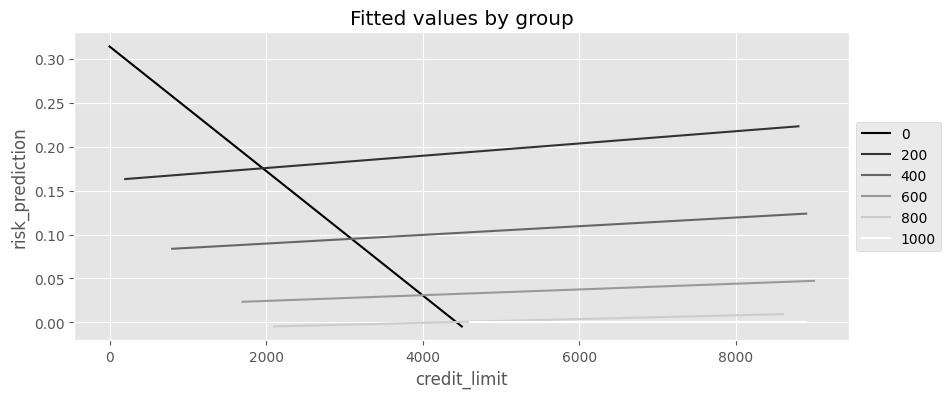

In [56]:
# plot of interaction model (aka saturated model)
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(['credit_limit', 'credit_score1_buckets']) 
          ['risk_prediction'] # for each credit limit, average prediction for each score bucket
          .mean()
          .reset_index()
          )

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x='credit_limit',
             y='risk_prediction',
             hue='credit_score1_buckets',
             palette='gray')
plt.title('Fitted values by group')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

#### Regression as Variance Weighted Average 

When we run the model without interaction terms for the conditional randomized data, we get a single effect: one slope parameter. This effect is slightly different in value from the one we got by estimating effect per group and averaging the results using group size as weights. So somehow regression is combining the effects from different groups and its not using a sample size weighted average, so what is it using? Regression uses weights that are proportional to the variance of the treatment in each group. Regression prefers groups where treatment varies a lot. If treatment doesnt change much within a group, how can you be sure of its effect? If treatment changes a lot, its impact on the outcome will be more evident.

If you have multiple groups where the treatment is randomizd inside each group, conditionality principle states that the effect is a weighted average of the effect inside each group.

$ATE = E [(\frac{\delta}{\delta t}E[Y_i|T=t, Group_i])w(Group_i)]$

With regression, $w(Group_i)\; \alpha \; \sigma ^ 2 (T)|Group$, but you can also choose to manually weight the group effects using the sample size as the weight: $w(Group_i)=N_{Group}$

In [57]:
np.random.seed(123)

# std(t) = 1
t1 = np.random.normal(0, 1, size=1000)  # continuous treatment from standard normal, mean=0, std=1 (lower var)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1,     # ATE of 1 
    g=1                                 # group cateogry indicator
))

# std(t)=2
t2 = np.random.normal(0, 2, size=500)   # continuous treatment from normal dist , mean=0, std=2 (higher var)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2, # ATE of 2
    g=2                                 # group cateogry indicator
))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [58]:
# effect of each group and average with group size as weights
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group * df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate   # size weighting moves the ate towards the larger group

1.3333333333333324

In [59]:
# regression while controlling for the groups
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params    # variance weighting moves the ate towards the group with greater variance

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

#### De-Meaning and Fixed Effects

If you have a ton of groups, then using dummy variables to account for different treatment assignments across groups, is tedious and computationally expensive. We can use the FWL technique in this case. 

The debiasing step involves predicting the treatment from covariates, in this case dummies.  Since dummies work as group averages, you predict the average treatment for the group, which is given by summing the intercept to the coefficient for that group. To residualize the treatment, you can do so in a much simpler and effective way. First, calculate the average treatment for each group. Then to get the residuals, subtract that group average from the treatment. Since this approach subtracts the average treatment, it is sometimes referred to as de-meaning the treatment. To do this with stats models regression formula, wrap the mathematical operation around I(...).

In [60]:
model_deb = smf.ols("credit_limit ~ C(credit_score1_buckets)", # regress continuous treatment against dummies
                    data=risk_data_rnd).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


In [61]:
risk_data_rnd.groupby("credit_score1_buckets")["credit_limit"].mean() # average treatment for each group

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [62]:
# average treatment for each group
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean"))
)

In [63]:
# regressing the outcome against the treatment residuals
model = smf.ols("default ~ I(credit_limit - credit_limit_avg)",  # get residuals by subtracting average
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


In [64]:
model = smf.ols("default ~ credit_limit + credit_limit_avg", # outcome against treatment
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


#### Omitted Variable Bias: Confounding Through the Lens of Regression

With regression, you can say that the bias due to an omitted variable is equal to the effect in the model where it is included plus the effect of the omitted variable on the outcome times the regression of omitted on included. First this means a simple regression of Y on T will be the true causal parameter $\tau$, plus a bias term. This bias term is the coefficient of the omitted confounder on the outcome, $\beta_{omitted}$ times the coefficient of regressing the omitted variable on the treatment, $\delta_{omitted}$

$\frac{Cov(T,Y)}{Var(T)}=\tau + \beta^{'}_{omitted} \delta_{omitted}$

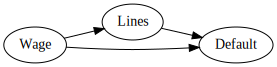

In [65]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("Lines", "Default")
g.edge("Wage", "Default")
g.edge("Wage", "Lines")

g

In [66]:
short_model = smf.ols("default ~ credit_limit", data=risk_data).fit()
short_model.params["credit_limit"]

-2.4019619925970212e-05

In [67]:
long_model = smf.ols("default ~ credit_limit + wage", data=risk_data).fit()
omitted_model = smf.ols("wage ~ credit_limit", data=risk_data).fit()

(long_model.params["credit_limit"] + long_model.params["wage"]*omitted_model.params["credit_limit"])

-2.401961992597028e-05

#### Neutral Controls

You don't want to include common effects (colliders) or mediators, as those would induce selection bias. Linear regression can be used not only to adjust confounder, but also to reduce noise, by including variables that are highly predictive of the outcome. In the example below, including credit_score2 decreases the standard error on credit_limit and increases its coefficient a bit.

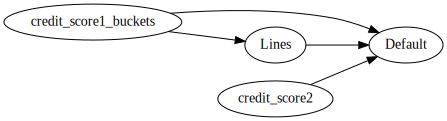

In [68]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default")
g.edge("credit_score1_buckets", "Lines")
g.edge("credit_score2", "Default")
g.edge("Lines", "Default")
g

In [69]:
formula = "default ~ credit_limit + C(credit_score1_buckets) + credit_score2"
model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


#### Noise Inducing Control

In the example below, let's say that you are interested in the effect of credit limit on spend rather than on risk. Credit limit was randomly assigned, given credit_score1, in a conditionally random experiment. This time, credit_score1 is not a confounder; it causes the treatment but not the outcome. This means that we don't need to adjust for credit_score1 to get the causal effect of credit limit on spend. A single variable regression model would do. In this case including credit_score_1_buckets can increase the noise ie increase standard error. OLS likes when the treatment has a high variance. But if you control for a covariate that explains the treatment, you are effectively reducing its variance.

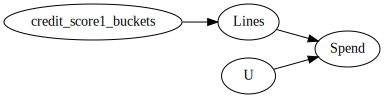

In [70]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})
g.edge("credit_score1_buckets", "Lines")
g.edge("U", "Spend")
g.edge("Lines", "Spend")

g

In [71]:
spend_data_rnd = pd.read_csv("data/spend_data_rnd.csv")

In [72]:
model = smf.ols("spend ~ np.sqrt(credit_limit)", data=spend_data_rnd).fit() # square root due to concavity
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [73]:
model = smf.ols("spend ~ np.sqrt(credit_limit) + C(credit_score1_buckets)", data=spend_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


#### Feature Selection: A Bias-Variance Trade-Off 

In reality, its hard to have a situation where a covariate causes the treatment but not the outcome. Most likely, you will have a bunch of confounders that cause both T and Y, but to different degrees. For example $X_1$ may be a strong cause of $T$ but a weak cause of $Y$ while $X_3$ may be a strong cause of $Y$ but a weak cause of $T$, and $X_2$ is somewhere in the middle.

Thus on one hand, if you want to get rid of all the biases, you must include all the covariates; they are confounders that need to be adjusted. On the other hand, adjusting for causes of the treatment will increase the variance of your estimator. 

If you try to estimate the causal effect while controlling for all of the confounders, the standard error of the estimate will be too high to conclude anything. If you know that one of the confounders is a strong predictor of the treatment and a weak predictor of the outcome, you can choose to drop it from the model. This will bias your estimate, but it may also decrease variance significantly.

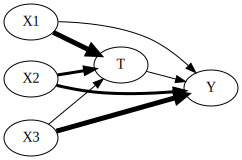

In [74]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

# thickness of the arrow indicates the strength of the association / causation
g.edge("X1", "T", penwidth="5")
g.edge("X2", "T", penwidth="3")
g.edge("X3", "T", penwidth="1")

g.edge("X1", "Y", penwidth="1")
g.edge("X2", "Y", penwidth="3")
g.edge("X3", "Y", penwidth="5")

g.edge("T", "Y")

g

In [75]:
np.random.seed(123)

n=100 
(x1,x2,x3) = (np.random.normal(0,1,n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [76]:
# dropping covariates
smf.ols("y~t+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


In [77]:
smf.ols("y~t+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1265,0.616,0.205,0.838,-1.095,1.348
t,0.2704,0.050,5.364,0.000,0.170,0.370
x3,10.4754,0.633,16.559,0.000,9.220,11.731
